#  Ensemble methods

 We use the Cogo labs dataset where we are trying ot predict customers' email open rates to identify who to target with an ad campaign. 

## Setup

Lets start by importing the necessary libraries and mounting the Google Drive:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import the data

The dataset we will use is the same that we used for the labs on descriptive analytics; refer to the earlier
descriptions for details. Let’s load the training data. Change the path below to accurately reflect the location
of the data on your Drive.

In [3]:
df = pd.read_csv('/content/drive/My Drive/MLBA/cogo-all.tsv', sep='\t')

## Train and Test Sets

We start by splitting the data into a training and testing set. We've done this manually before, but today we'll use Scikit-learn's `train_test_split` function. 

In [ ]:
X = df.loc[:, df.columns != "p_open"] 
y = df["p_open"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

The dataset is quite large and, depending on the method, training may be pretty slow. Let's sample 5000 instances from the training set to use to speed up training while we are experimenting, then we can return to the full dataset once we are ready. 

In [5]:
train_sample_size = 5000

df_train = X_train.copy()
df_train["p_open"] = y_train 

# Randomly sample 5000 rows from the training data
df_train_sample = df_train.sample(n=train_sample_size, random_state=5) 

We can assign descriptive names to the (sampled) training instances and outcomes. Of course, by now you should have a better idea of which predictors to use. Refer back to previous labs if you can't remember how to handle categorical variables or apply transformations to variables. 

In [ ]:
# it's up to you to add more predictors as you see fit
predictors = ["browser1", "browser2", "browser3", "activity_days"]
X_train_sample = df_train_sample[predictors]
y_train_sample = df_train_sample["p_open"][:, np.newaxis]
y_train_sample.shape

## Random forests

We've used [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to train basic decision trees. Similarly, we will use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for bagging and random forests.

These models have several parameters that you will have to pay attention to, including the following: 

*   `n_estimators`: the number of trees in the forest;
*   `criterion`: metric used to pick a split, as in decision trees; 
*   `max_depth`, `min_samples_split`, `min_samples_leaf`, etc: different ways of controlling the complexity of the tree; 
*   `max_features`: the number of predictors to consider at every split, the default behaviour is $\sqrt{p}$ for classification and $p$ for regression (you probably want to start with something like $p/2$ instead for regression); 
*   `max_samples`: the number of samples to draw when bootstrap sampling, the default is to draw a number of bootstrap samples equal to the size of the training set.

For the purposes of illustration, let's train a random forest consisting of 50 decision stumps (`max_depth=1`). 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, max_depth=1, max_features=2)
rf.fit(X_train_sample, y_train_sample)

Let's see how we do on the training set. As always, we have the `predict()` method available. 

In [9]:
from sklearn.metrics import mean_squared_error
y_hat_train = rf.predict(X_train_sample)
mse_train = mean_squared_error(y_hat_train, y_train_sample)
mse_train

0.027943456364491828

If we were doing binary regression, we would also be interested in the `predict_proba()`, which predicts the probability for each of the classes. In other words, if the output classes are 0 or 1, `predict_proba()` returns a vector containing (*probability of label 0*, *probability of label 1*).

### Feature importance

Something that ensemble methods allow us to do that is harder in basic decision trees, is to estimate the importance of various features. This gives a measure of how much accuracy improved/error decreased (or reduction in Gini impurity, depending on which metric we are using) when splitting on a feauture, on average across all the times a feature was considered in any of the trees. The attribute `feature_importances_` returns a vector of normalised importances for each of the predictors. 

In [10]:
rf.feature_importances_

array([0.08, 0.08, 0.42, 0.42])

We can reformat this a bit by appending the name of the predictor to its importance and sorting in decreasing order. 

In [11]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
predictor_importances = [(predictor, round(importance, 2)) for predictor, importance in zip(predictors, importances)]
# Sort the feature importances by most important first
predictor_importances = sorted(predictor_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in predictor_importances] ;

Variable: browser3             Importance: 0.42
Variable: activity_days        Importance: 0.42
Variable: browser1             Importance: 0.08
Variable: browser2             Importance: 0.08


Now let's plot it. Make sure you understand how we are using matplotlib here. 

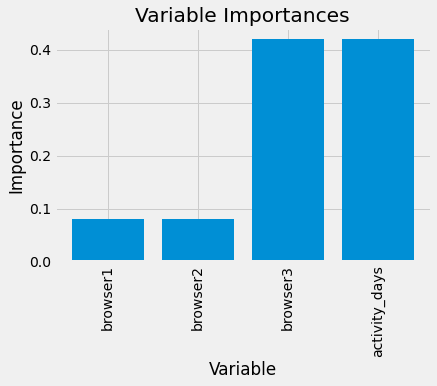

In [12]:
# a style I've stared at way too much this last week
plt.style.use('fivethirtyeight')

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, predictors, rotation='vertical') # Tick labels for x axis
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances');

You can use feature importance to do feature selection, if needed. We can also plot individual trees in the ensemble by inspecting the `estimators_` attribute. We use the tree library library for plotting as before. 
Remember that we are training decision stump, so each of the trees consists of a single split. 

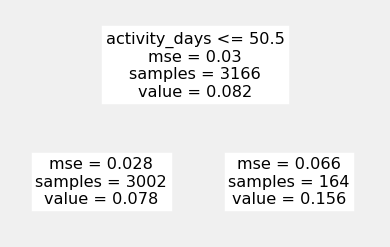

In [13]:
from sklearn import tree
tree.plot_tree(rf.estimators_[22], feature_names=predictors); # try trees 22, 28

## Boosting

We will use an implementation of the AdaBoost algorithm to train boosted forests with [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) (or [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)). The  arguments we care most about are: 

* `base_estimator`: The estimator to train at every step, by default `DecisionTreeRegressor(max_depth=3)`.
*  `n_classifiers`: The number of trees to train. 
*  `learning_rate`: Essentially the crushing parameter we discussed in class. Each classifier's contribution to the final model is shrunk by the learning rate. 

Let's do boosting with decision stumps (decision trees of depth 1).

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

num_trees = 100
decision_stump = DecisionTreeRegressor(max_depth=1)

adaboost = AdaBoostRegressor(base_estimator=decision_stump, n_estimators=num_trees, learning_rate=0.1)
adaboost.fit(X_train_sample, y_train_sample);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Generalizing ensemble methods

We have focused on bagging and boosting in the context of decision trees but the principles are general. For example, the `AdaBoostRegressor` (and classifier) has an argument `base_estimator` which, by default, is `DecisionTreeRegressor(max_depth=3)`, but this can be changed to any other estimator. 


*Stacking* goes even further: you train multiple classifiers of different types (for example ridge, lasso and decision tree) on the same data, use each classifier to make a prediction on every instance, then these predictions are fed as features into a final classifier (often logistic regression) which combines all of the different predictions into a single final prediction. You can find some more information on this idea [here](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization), or take a look at the documentation for [`StackingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) (or regressor). 